In [1]:
import sys
!{sys.executable} -m pip install s3fs

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [10]:
from __future__ import print_function
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import io

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()

In [5]:
s3_bucket = 'cloud-bucket-test'  # replace with an existing bucket if needed
#s3_bucket = sagemaker.Session().default_bucket() 
s3_prefix = 'deepar-azure-notebook'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [6]:
region = sagemaker_session.boto_region_name
print(region)

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

us-east-1


In [7]:
print("region name: {}".format(region))
print("s3_data_path: {}".format(s3_data_path))
print("s3_output_path: {}".format(s3_output_path))

region name: us-east-1
s3_data_path: s3://cloud-bucket-test/deepar-azure-notebook/data
s3_output_path: s3://cloud-bucket-test/deepar-azure-notebook/output


In [8]:
#Next, we configure the container image to be used for the region that we are running in.
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [ ]:
# import the Azure dataset which has the maxcpu readings for a period of one year

In [13]:
mykey= "azure-dataset/cleaned_data.csv"
client = boto3.client('s3')
obj = client.get_object(Bucket=s3_bucket, Key=mykey)
data = pd.read_csv(io.BytesIO(obj['Body'].read()), index_col=0, parse_dates=True, encoding='utf8')

In [14]:
data.head()

,Timestamp,maxcpu
0,2020-01-01 00:00:00,66.909246
1,2020-01-01 01:00:00,6.510768
2,2020-01-01 02:00:00,66.956558
3,2020-01-01 03:00:00,98.795780
4,2020-01-01 04:00:00,6.472197


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8040 entries, 0 to 8039
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  8040 non-null   object 
 1   maxcpu     8040 non-null   float64
dtypes: float64(1), object(1)
memory usage: 188.4+ KB


In [16]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

In [24]:
data = data.set_index("Timestamp")

In [25]:
data.isnull().sum()

maxcpu    0
dtype: int64

In [122]:
data.index[-1]

Timestamp('2020-11-30 23:00:00')

In [124]:
print(data.index.freq)

None


In [26]:
data_cpu = data.copy()
data_cpu.shape

(8040, 1)

In [27]:
num_timeseries = data_cpu.shape[1]
print("num_timeseries = {}".format(num_timeseries))

num_timeseries = 1


In [28]:
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_cpu.iloc[:,i], trim='f'))

In [31]:
timeseries[0]

Timestamp
2020-01-01 00:00:00    66.909246
2020-01-01 01:00:00     6.510768
2020-01-01 02:00:00    66.956558
2020-01-01 03:00:00    98.795780
2020-01-01 04:00:00     6.472197
                         ...    
2020-11-30 19:00:00    89.453653
2020-11-30 20:00:00    98.841736
2020-11-30 21:00:00    70.042481
2020-11-30 22:00:00    47.881668
2020-11-30 23:00:00    80.857566
Name: maxcpu, Length: 8040, dtype: float64

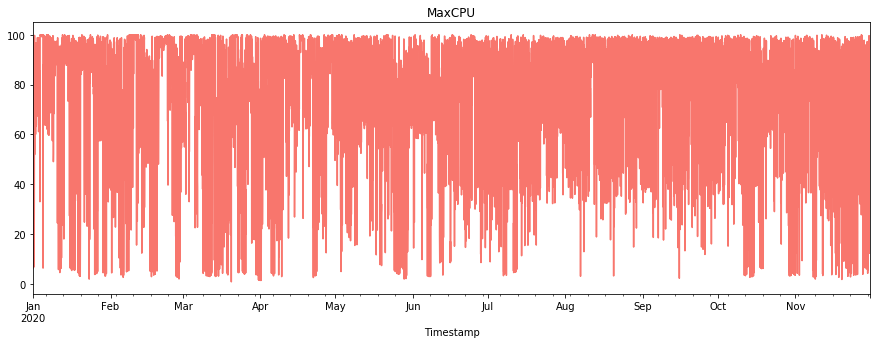

In [172]:
# plot the whole timeseries---the maxcpu data ranging from 0-8040 samples
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
timeseries[0].plot(style='-', figsize=(15,5), color=color_pal[0], title='MaxCPU')
plt.show()



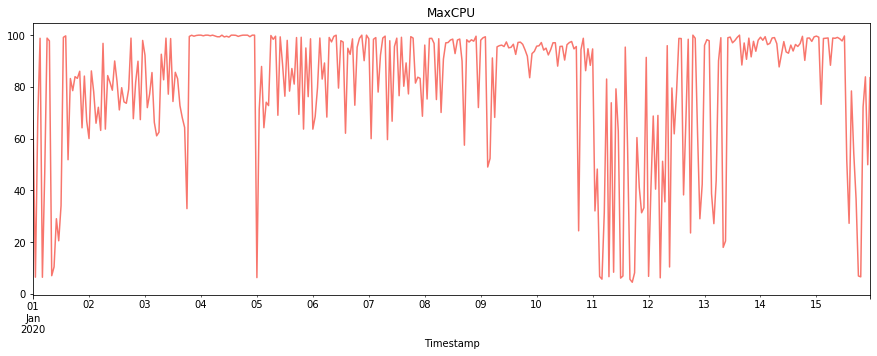

In [173]:
# Plot the first fifteen days of data--maxcpu
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
timeseries[0].loc["2020-01-01":"2020-01-15"].plot(style='-', figsize=(15,5), color=color_pal[0], title='MaxCPU')
plt.show()



In [102]:
# we use 1 hour frequency for the time series
freq = 'H'

# we predict for 4 days
prediction_length = 4 * 24

# we also use 4 days as context length, this is the number of state updates accomplished before making predictions
context_length = 4 * 24

In [103]:
prediction_length

96

In [104]:
#We specify here the portion of the data that is used for training: the model sees data from 2020-01-01 to 2020-09-01 for training.
start_dataset = pd.Timestamp("2020-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2020-09-01 00:00:00", freq=freq)
print("start_dataset = {}".format(start_dataset))
print("end_training = {}".format(end_training))

start_dataset = 2020-01-01 00:00:00
end_training = 2020-09-01 00:00:00


In [105]:
start_dataset

Timestamp('2020-01-01 00:00:00', freq='H')

In [106]:
end_training

Timestamp('2020-09-01 00:00:00', freq='H')

In [61]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - timedelta(days=1)].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

1


In [54]:
training_data

[{'start': '2020-01-01 00:00:00',
  'target': [66.909246,
   6.510768,
   66.956558,
   98.79578,
   6.472197,
   46.746097,
   98.856803,
   97.791176,
   7.088011999999999,
   10.474168,
   29.099921,
   20.569588,
   34.137151,
   99.15191,
   99.72967,
   51.876758,
   83.24804300000002,
   78.560455,
   83.96804499999998,
   83.313001,
   86.058782,
   64.200055,
   84.195488,
   66.79601600000001,
   60.061861,
   86.186817,
   78.121973,
   65.97620400000001,
   72.14338000000002,
   63.206971,
   96.831246,
   63.70898100000001,
   84.387771,
   81.725102,
   78.728734,
   90.021959,
   82.133367,
   71.115279,
   79.701041,
   74.220091,
   73.685588,
   79.081604,
   98.859332,
   67.730316,
   81.790858,
   89.939871,
   67.362623,
   97.961426,
   92.251785,
   71.998372,
   77.251162,
   85.555346,
   66.322265,
   61.109927,
   62.526618000000006,
   92.629157,
   82.753045,
   98.851198,
   77.204065,
   98.679507,
   74.36989799999998,
   85.65684,
   83.138015,
   72.7

In [62]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(days=k * prediction_length)].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

4


In [80]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [81]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 12.9 ms, sys: 8.12 ms, total: 21 ms
Wall time: 20 ms


In [82]:
# Lets copy our data to s3

s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    print(split)
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [83]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

['s3:', '', 'cloud-bucket-test', 'deepar-azure-notebook', 'data', 'train', 'train.json']
Uploading file to s3://cloud-bucket-test/deepar-azure-notebook/data/train/train.json
['s3:', '', 'cloud-bucket-test', 'deepar-azure-notebook', 'data', 'test', 'test.json']
Uploading file to s3://cloud-bucket-test/deepar-azure-notebook/data/test/test.json
CPU times: user 37.1 ms, sys: 12 ms, total: 49.1 ms
Wall time: 1.38 s


In [84]:
# see what we wrote to s3
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2020-01-01 00:00:00", "target": [66.909246, 6.510768, 66.956558, 98.79578, 6.472197, 46.7...


In [85]:
#Train the model
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-azure-job',
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [86]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [87]:
estimator.set_hyperparameters(**hyperparameters)

In [88]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2020-12-02 01:04:57 Starting - Starting the training job......
2020-12-02 01:05:49 Starting - Launching requested ML instances.........
2020-12-02 01:07:04 Starting - Preparing the instances for training...
2020-12-02 01:07:55 Downloading - Downloading input data...
2020-12-02 01:08:28 Training - Downloading the training image...
2020-12-02 01:08:47 Training - Training image download completed. Training in progress.Arguments: train
[12/02/2020 01:08:50 INFO 140116079093568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality'

In [89]:
from sagemaker.serializers import IdentitySerializer

In [90]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [91]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

---------------!

In [94]:
timeseries[0]

Timestamp
2020-01-01 00:00:00    66.909246
2020-01-01 01:00:00     6.510768
2020-01-01 02:00:00    66.956558
2020-01-01 03:00:00    98.795780
2020-01-01 04:00:00     6.472197
                         ...    
2020-11-30 19:00:00    89.453653
2020-11-30 20:00:00    98.841736
2020-11-30 21:00:00    70.042481
2020-11-30 22:00:00    47.881668
2020-11-30 23:00:00    80.857566
Name: maxcpu, Length: 8040, dtype: float64

In [96]:
ts=timeseries[0]

In [131]:
payload = ts.values[-96:]

In [107]:
print(ts.index.freq)

None


In [108]:
ts.index[-1]

Timestamp('2020-11-30 23:00:00')

In [109]:
predictor.predict(ts=timeseries[0], quantiles=[0.10, 0.5, 0.90])

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

In [111]:
dates = pd.date_range(start="1-1-2020", end="1-2-2020", freq="H")

In [115]:
np.random.randn(25)

array([ 0.34361829, -1.76304016,  0.32408397, -0.38508228, -0.676922  ,
        0.61167629,  1.03099952,  0.93128012, -0.83921752, -0.30921238,
        0.33126343,  0.97554513, -0.47917424, -0.18565898, -1.10633497,
       -1.19620662,  0.81252582,  1.35624003, -0.07201012,  1.0035329 ,
        0.36163603, -0.64511975,  0.36139561,  1.53803657, -0.03582604])

In [117]:
x = pd.DataFrame({"abc":np.random.randn(25)},index=dates)

In [118]:
x

,abc
2020-01-01 00:00:00,0.261055
2020-01-01 01:00:00,0.005113
2020-01-01 02:00:00,-0.234587
2020-01-01 03:00:00,-1.415371
2020-01-01 04:00:00,-0.420645
2020-01-01 05:00:00,-0.342715
2020-01-01 06:00:00,-0.802277
2020-01-01 07:00:00,-0.161286
2020-01-01 08:00:00,0.404051
2020-01-01 09:00:00,1.886186


In [119]:
x.index[-1]

Timestamp('2020-01-02 00:00:00', freq='H')

In [120]:
x.index.freq

<Hour>

In [121]:
x.index[-1]+x.index.freq

Timestamp('2020-01-02 01:00:00', freq='H')

In [125]:


predictor.delete_endpoint()



In [142]:
job_name = estimator.latest_training_job.name
print("job_name: {}".format(job_name))

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    image_uri=image_name,
    role=role
)



job_name: deepar-azure-job-2020-12-02-01-04-56-379
-------------------!

In [143]:
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session,
    serializer=IdentitySerializer(content_type="application/json"))
    #content_type="application/json")
    

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [144]:
payload_list = payload.tolist()

In [145]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(year, data):
    #year_temps = data[str(year)]
    s = {"start": "{}-01-01 00:00:00".format(year), "target": data}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

In [146]:
out = buildPredictionData("2020", payload_list)

In [147]:
out

'{"instances": [{"start": "2020-01-01 00:00:00", "target": [36.800584, 31.988378000000004, 88.851267, 33.288953, 98.658927, 95.961114, 50.112346, 87.783424, 84.212749, 67.217389, 94.223408, 27.729536, 100.0, 82.549844, 91.424498, 84.653366, 78.632657, 34.160270000000004, 65.605981, 99.682177, 73.284823, 94.867067, 87.74511899999997, 86.311122, 79.73743, 3.845575, 96.722154, 47.234993, 29.873103000000004, 4.545428, 28.271145, 94.577993, 79.917475, 75.122757, 96.070989, 80.098673, 87.398107, 87.277079, 97.780198, 77.210626, 16.57154, 78.74548399999998, 7.169291, 8.209721, 83.07182399999998, 6.522054, 95.988512, 79.468109, 91.394782, 95.13798, 76.978021, 92.63646, 79.754832, 29.774489000000006, 30.7191, 93.214897, 78.854089, 21.29288, 75.948065, 85.578017, 5.971978, 9.014594, 69.770505, 73.431046, 91.755343, 79.702093, 81.415642, 97.221776, 78.745785, 45.376215, 94.138121, 37.655799, 4.246782, 48.743738, 67.91766899999999, 41.66435300000001, 59.24374200000001, 5.758188, 83.51952800000002,

In [149]:
result = predictor.predict(out)

In [150]:
result

b'{"predictions":[{"quantiles":{"0.1":[50.2184333801,47.6965560913,50.0729293823,40.5705337524,49.7836914062,54.8560600281,53.3143882751,58.7686576843,47.9284629822,59.6440010071,45.7050361633,41.8870925903,54.6169281006,60.82837677,58.2393379211,57.7074584961,57.7407798767,53.9094734192,54.4515609741,59.9621543884,61.5385513306,56.0939483643,57.4214019775,51.2618789673,54.3437652588,60.1338424683,44.8802604675,60.2856483459,55.5121231079,50.6399993896,50.7330780029,58.7500305176,61.4420318604,65.4139556885,67.0828170776,68.8484344482,67.2892303467,67.839805603,68.6880874634,72.5847320557,76.4655151367,78.6327133179,82.0614624023,83.0379333496,77.1786727905,85.257774353,79.2541351318,85.8441619873,85.9667358398,80.7874221802,84.6256713867,87.3783493042,83.4035491943,84.8512802124,83.1784286499,76.8314971924,78.6461791992,74.6849212646,74.8057327271,75.8036575317,80.5840835571,73.6296691895,74.2808074951,74.4734268188,78.4028778076,80.1988525391,84.0750427246,77.4591445923,79.6823043823

In [154]:
results = json.loads(result)

In [163]:
with open("deepARazure.json", 'w') as f:
    json.dump(results, f)

In [155]:
results["predictions"][0]

{'quantiles': {'0.1': [50.2184333801,
   47.6965560913,
   50.0729293823,
   40.5705337524,
   49.7836914062,
   54.8560600281,
   53.3143882751,
   58.7686576843,
   47.9284629822,
   59.6440010071,
   45.7050361633,
   41.8870925903,
   54.6169281006,
   60.82837677,
   58.2393379211,
   57.7074584961,
   57.7407798767,
   53.9094734192,
   54.4515609741,
   59.9621543884,
   61.5385513306,
   56.0939483643,
   57.4214019775,
   51.2618789673,
   54.3437652588,
   60.1338424683,
   44.8802604675,
   60.2856483459,
   55.5121231079,
   50.6399993896,
   50.7330780029,
   58.7500305176,
   61.4420318604,
   65.4139556885,
   67.0828170776,
   68.8484344482,
   67.2892303467,
   67.839805603,
   68.6880874634,
   72.5847320557,
   76.4655151367,
   78.6327133179,
   82.0614624023,
   83.0379333496,
   77.1786727905,
   85.257774353,
   79.2541351318,
   85.8441619873,
   85.9667358398,
   80.7874221802,
   84.6256713867,
   87.3783493042,
   83.4035491943,
   84.8512802124,
   83.178428

In [156]:
first_quantile_results = results["predictions"][0]['quantiles']['0.1']

In [157]:
len(first_quantile_results)

96

In [165]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]
    return y_mean, y_q1, y_q2, y_sample

In [169]:
from pylab import rcParams
rcParams['figure.figsize'] = (12,6)


In [182]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

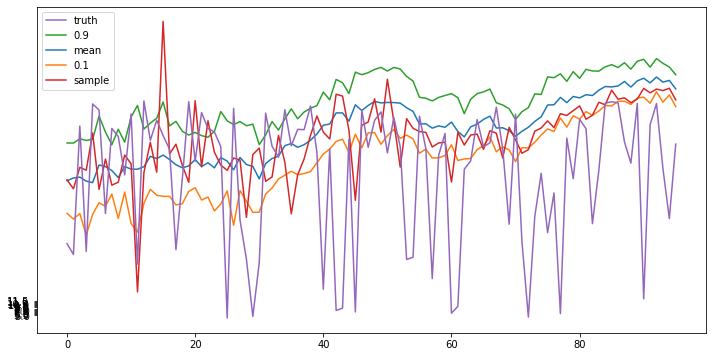

In [183]:
plotSeries(result, 
           truth=True, 
           truth_data=payload_list, 
           truth_label='truth')

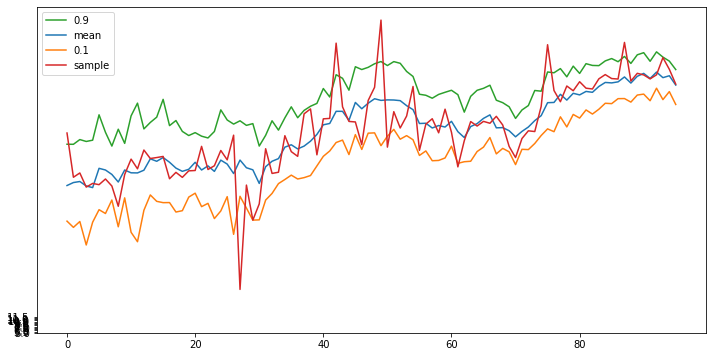

In [193]:
plotSeries(result)